In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import calendar
from utils import *
import quantstats as qs

The entire date range is from 2019-12-27 00:00:00 to 2023-10-31 00:00:00 (1404 days 00:00:00)


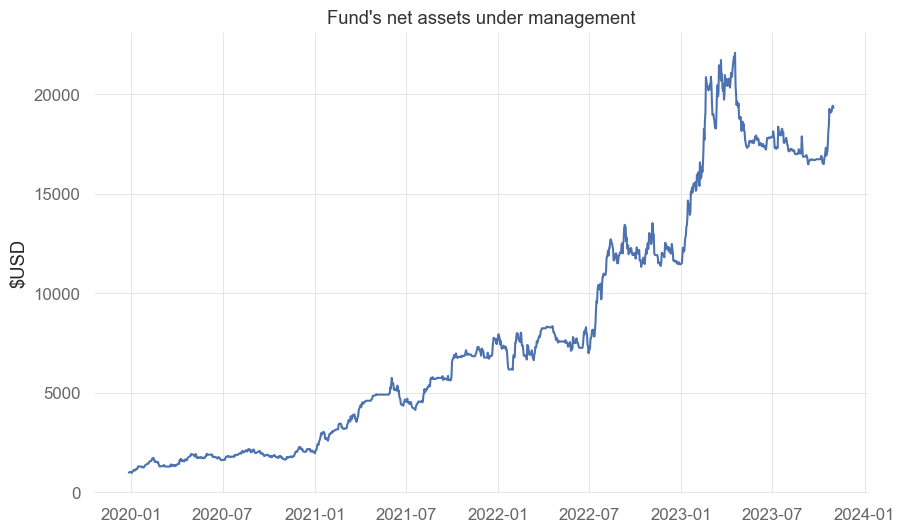

In [2]:
# Data and super variables
# Import the data for fund 1
f1_DailyAuM = pd.read_csv("./Data/Daily AuM - AuM (1).csv")
f1_DailyTrades = pd.read_csv("./Data/Daily AuM - Trades_10.csv")

# Get the union of both datasets (Date-wise)
f1_DailyAuM.Date = pd.to_datetime(f1_DailyAuM.Date, dayfirst = True, format = "mixed")
f1_DailyTrades.buy_date = pd.to_datetime(f1_DailyTrades.buy_date, dayfirst = True, format = "mixed")
f1_DailyTrades.sell_date = pd.to_datetime(f1_DailyTrades.sell_date, dayfirst = True, format = "mixed")

f1_DailyTrades_LastDate = f1_DailyTrades.iloc[-1].sell_date
f1_DailyAuM_LastDate = f1_DailyAuM.iloc[-1].Date

if f1_DailyTrades_LastDate < f1_DailyAuM_LastDate:
    f1_DailyAuM = f1_DailyAuM[f1_DailyAuM.Date <= f1_DailyTrades_LastDate]
else:
    f1_DailyTrades = f1_DailyTrades[f1_DailyTrades.sell_date <= f1_DailyAuM_LastDate]

# start and end of date of the entire dataset
START_DATE, END_DATE = f1_DailyAuM.iloc[0].Date, f1_DailyAuM.iloc[-1].Date 
START_MONTH, END_MONTH = f1_DailyAuM.iloc[0].Date.month, f1_DailyAuM.iloc[-1].Date.month 
START_YEAR, END_YEAR = f1_DailyAuM.iloc[0].Date.year, f1_DailyAuM.iloc[-1].Date.year 

print(f"The entire date range is from {START_DATE} to {END_DATE} ({(f1_DailyAuM.iloc[-1].Date - f1_DailyAuM.iloc[0].Date)})")

plt.plot(f1_DailyAuM.Date, f1_DailyAuM.AuM); plt.title("Fund's net assets under management"); plt.ylabel("$USD"); plt.show()

In [3]:
# Growth rate of fund net worth
# This metric is calculated on three intervals, six months, 1 year and 3 years
print("Metric: Growth rate of fund net worth")
range_6Mo = divideDateRange(START_DATE, END_DATE, "months", 6)
range_1Yr = divideDateRange(START_DATE, END_DATE, "years", 1)
range_3Yrs = divideDateRange(START_DATE, END_DATE, "years", 3)

tmpAuM_6Mo = f1_DailyAuM[(range_6Mo[1]<f1_DailyAuM.Date)&(f1_DailyAuM.Date<=range_6Mo[0])]
growthRate_6Mo = netGrowthRate(tmpAuM_6Mo.iloc[-1].AuM, tmpAuM_6Mo.iloc[0].AuM)

tmpAuM_1Yr = f1_DailyAuM[(range_1Yr[1]<f1_DailyAuM.Date)&(f1_DailyAuM.Date<=range_1Yr[0])]
growthRate_1Yr = netGrowthRate(tmpAuM_1Yr.iloc[-1].AuM, tmpAuM_1Yr.iloc[0].AuM)

tmpAuM_3Yrs = f1_DailyAuM[(range_3Yrs[1]<f1_DailyAuM.Date)&(f1_DailyAuM.Date<=range_3Yrs[0])]
growthRate_3Yrs = netGrowthRate(tmpAuM_3Yrs.iloc[-1].AuM, tmpAuM_3Yrs.iloc[0].AuM)

print(f"6 months growth rate (%) = {growthRate_6Mo*100} calculated from {tmpAuM_6Mo.iloc[-1].Date} to {tmpAuM_6Mo.iloc[0].Date}")
print(f"1 year growth rate (%) = {growthRate_1Yr*100} calculated from {tmpAuM_1Yr.iloc[-1].Date} to {tmpAuM_1Yr.iloc[0].Date}")
print(f"3 years growth rate (%) = {growthRate_3Yrs*100} calculated from {tmpAuM_3Yrs.iloc[-1].Date} to {tmpAuM_3Yrs.iloc[0].Date}")


Metric: Growth rate of fund net worth
6 months growth rate (%) = 6.466098804415761 calculated from 2023-10-31 00:00:00 to 2023-05-01 00:00:00
1 year growth rate (%) = 51.99868206878268 calculated from 2023-10-31 00:00:00 to 2022-11-01 00:00:00
3 years growth rate (%) = 1061.9410420879992 calculated from 2023-10-31 00:00:00 to 2020-11-01 00:00:00


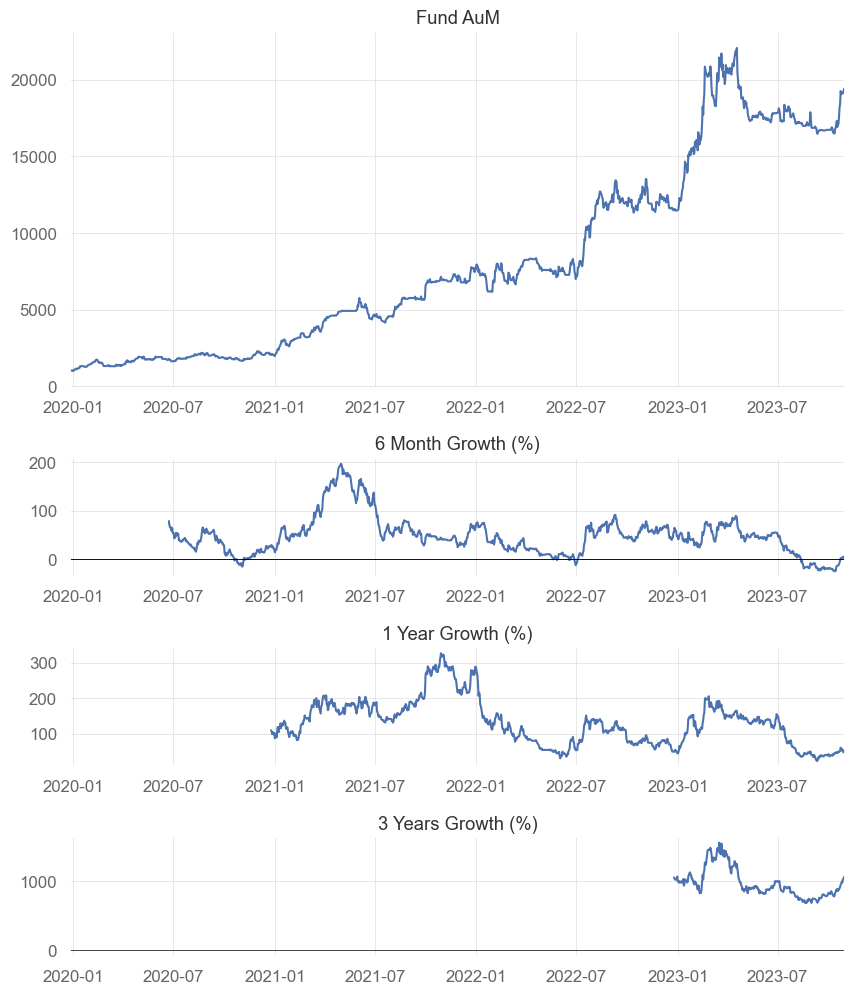

In [168]:
return_6M = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 180)).dropna()
return_1Y = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 365)).dropna()
return_3Y = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 365*3)).dropna()

subPlots = [return_6M,return_1Y,return_3Y]
plotTitle = ["Fund AuM", "6 Month Growth (%)", "1 Year Growth (%)", "3 Years Growth (%)"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [5]:
# Up/Down capture return
# Getting the monthly return of the Fund's AuM
print("Metric: Up/Down capture return")
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    fundReturns = getMonthlyReturns(f1_DailyAuM)
    barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
    barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)

    df = pd.concat([fundReturns.Date, fundReturns.fundReturn, barclayReturns.barclayReturn], axis = 1)
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Up capture
    upDf = dfCumulativeReturn[0 <= dfCumulativeReturn.barclayReturn]
    upCapture = calcCaptureRate(upDf[["fundReturn", "barclayReturn"]])
    # Down capture
    dnDf = dfCumulativeReturn[dfCumulativeReturn.barclayReturn <= 0]
    dnCapture = calcCaptureRate(dnDf[["fundReturn", "barclayReturn"]])

    print(f"{i[0]} {i[1]}:        up capture rate: {upCapture}   |    down capture rate: {dnCapture}")

Metric: Up/Down capture return
6 months:        up capture rate: 9.752609614561386   |    down capture rate: -7.2632011214009795
1 years:        up capture rate: 12.195528075745324   |    down capture rate: -7.263201121400992
3 years:        up capture rate: 44.21875334324256   |    down capture rate: 0


In [6]:
# Win ratio
print("Metric: Win ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM).sort_values("Date", ascending=False)
tmp =fundReturns.iloc[0:6,:]
winRatio = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"6 months win ratio: {winRatio}")

tmp =fundReturns.iloc[0:12,:]
winRatio = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"1 year win ratio: {winRatio}")

tmp =fundReturns.iloc[0:36,:]
winRatio = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"3 years win ratio: {winRatio}")

Metric: Win ratio
6 months win ratio: 0.3333333333333333
1 year win ratio: 0.3333333333333333
3 years win ratio: 0.6111111111111112


In [7]:
# Jensen's alpha
print("Metric: Jensen's alpha")
fundReturns = getMonthlyReturns(f1_DailyAuM)
fundReturns =  fundReturns[(START_DATE <= fundReturns.Date)&(fundReturns.Date <= END_DATE)].reset_index(drop=True)
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)
rfReturn = loadRiskFreeReturn("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, barclayReturns.barclayReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","jensenAlpha"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Calculate beta for each interval
    dfCumulativeReturn["beta"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        tempFund = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
        tempBenchmark = barclayReturns[(row.intervalStart<=barclayReturns.Date)&(barclayReturns.Date<=row.intervalEnd)]
        dfCumulativeReturn.iloc[i,-1] = calc_beta(tempFund.fundReturn, tempBenchmark.barclayReturn)

    # Calculate Jensen's alpha for each interval
    dfCumulativeReturn["jensenAlpha"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcJensenAlpha(row.fundReturn, row.barclayReturn, row.rfReturn, row.beta)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption("Jensen's alpha")

Metric: Jensen's alpha


,intervalStart,intervalEnd,fundReturn,barclayReturn,rfReturn,beta,jensenAlpha
6 months,2023-04-01 00:00:00,2023-09-30 00:00:00,-0.166019,0.030844,-0.020875,0.835919,-0.188377
6 months,2022-10-01 00:00:00,2023-03-31 00:00:00,0.652258,0.016570,0.355862,2.036242,0.987278
6 months,2022-04-01 00:00:00,2022-09-30 00:00:00,0.624562,-0.043082,1.087427,9.101785,9.826783
6 months,2021-10-01 00:00:00,2022-03-31 00:00:00,0.087364,-0.031520,1.203668,3.569241,3.292380
6 months,2021-04-01 00:00:00,2021-09-30 00:00:00,0.801733,0.059393,0.256576,9.002192,2.320234
6 months,2020-10-01 00:00:00,2021-03-31 00:00:00,0.534736,0.125019,1.610394,4.619064,5.785384
6 months,2020-04-01 00:00:00,2020-09-30 00:00:00,0.539160,0.055612,-0.740993,0.979671,0.499742
1 year,2022-10-01 00:00:00,2023-09-30 00:00:00,0.377952,0.047925,0.327558,1.694001,0.524093
1 year,2021-10-01 00:00:00,2022-09-30 00:00:00,0.766490,-0.073244,3.599997,7.099808,23.245800
1 year,2020-10-01 00:00:00,2021-09-30 00:00:00,1.765184,0.191837,2.280157,4.385595,8.643555


In [8]:
# Calmar ratio
print("Metric: Calmar ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)

# Note, to use quanstats, the Date column has to be dataframe's index column
fundReturns =  fundReturns[(START_DATE <= fundReturns.Date)&(fundReturns.Date <= END_DATE)].reset_index(drop=True).set_index("Date")

# 6 months
calmar = qs.stats.calmar(fundReturns.iloc[-7:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

# 1 year
calmar = qs.stats.calmar(fundReturns.iloc[-13:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

# 3 years
calmar = qs.stats.calmar(fundReturns.iloc[-37:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

Metric: Calmar ratio
6 months calmar ratio: -1.597221101868814
6 months calmar ratio: 1.642781430337797
6 months calmar ratio: 3.4341676010729554


In [9]:
# Treynor ratio
print("Metric: Treynor ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)
rfReturn = loadRiskFreeReturn("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","TreynorRatio"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Calculate beta for each interval
    dfCumulativeReturn["beta"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        tempFund = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
        tempBenchmark = barclayReturns[(row.intervalStart<=barclayReturns.Date)&(barclayReturns.Date<=row.intervalEnd)]
        dfCumulativeReturn.iloc[i,-1] = calc_beta(tempFund.fundReturn, tempBenchmark.barclayReturn)

    # Calculate Jensen's alpha for each interval
    dfCumulativeReturn["TreynorRatio"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcTreynorRatio(row.fundReturn, row.rfReturn, row.beta)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption('Treynor Ratio')


Metric: Treynor ratio


,intervalStart,intervalEnd,fundReturn,rfReturn,beta,TreynorRatio
6 months,2023-05-01 00:00:00,2023-10-31 00:00:00,-0.167980,0.249906,0.311975,-1.339486
6 months,2022-11-01 00:00:00,2023-04-30 00:00:00,0.649983,-0.049477,2.131776,0.328111
6 months,2022-05-01 00:00:00,2022-10-31 00:00:00,0.451293,0.596280,8.288086,-0.017493
6 months,2021-11-01 00:00:00,2022-04-30 00:00:00,0.195608,1.765069,4.007788,-0.391603
6 months,2021-05-01 00:00:00,2021-10-31 00:00:00,0.373640,0.170035,5.075353,0.040116
6 months,2020-11-01 00:00:00,2021-04-30 00:00:00,1.343934,2.217724,1.778352,-0.491348
6 months,2020-05-01 00:00:00,2020-10-31 00:00:00,0.279866,-0.297100,8.146153,0.070827
1 year,2022-11-01 00:00:00,2023-10-31 00:00:00,0.372819,0.188065,2.301895,0.080262
1 year,2021-11-01 00:00:00,2022-10-31 00:00:00,0.735178,3.413826,5.997034,-0.446662
1 year,2020-11-01 00:00:00,2021-10-31 00:00:00,2.219721,2.764849,3.457398,-0.157670


In [10]:
# Sortino ratio
print("Metric: Sortino ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)
rfReturn = loadRiskFreeReturn("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","Sortino"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Get the days that fund had negative returns
    dfCumulativeReturn["beta"] = 0.
    nReturn = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
    nReturn = nReturn[nReturn.fundReturn<0]

    # Calculate Jensen's alpha for each interval
    dfCumulativeReturn["Sortino"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcSortinoRatio(row.fundReturn, row.rfReturn, nReturn.rfReturn)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption('Sortino Ratio')

Metric: Sortino ratio


AttributeError: 'DataFrame' object has no attribute 'rfReturn'